In [1]:
# %reset
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline



%load_ext Cython

# # This routine computes the density field and save results to file
# def compute_df(snapshot, ptypes, grid, fout):
#     # if not(os.path.exists(snapshot+'.0')) and not(os.path.exists(snapshot+'.0.hdf5')):
#         # return 0
#     print(snapshot)
#     df = MASL.density_field_gadget(snapshot, ptypes, grid, MAS='CIC',
#                                    do_RSD=False, axis=0, verbose=True)
#     df = df/np.mean(df, dtype=np.float64)-1.0
#     np.save(fout, df)
    

    
    



In [2]:
%load_ext Cython



The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [3]:
isim_fid = 4
snapnum = 3
mass_type = 'rockstar_200c'
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
snapdir = snap_dir_base + '/' + str(isim_fid)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
if mass_type == 'rockstar_vir':
    index_M = header.index('Mvir')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
if mass_type == 'rockstar_200c':
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h

Mmin_cut = 1e13
lgMass_truth = np.log10(mass_truth)
indsel = np.where(mass_truth > Mmin_cut)[0]
# print(grid, len(indsel), len(mass_truth), np.amin(lgMass_truth), np.log10(Mmin_cut))
pos_h_truth = pos_h_truth[indsel]
lgMass_truth = lgMass_truth[indsel]




/tmp/ipykernel_238297/2083256906.py:20: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth)


In [4]:
%%cython

cimport numpy as np
cpdef void NGP_mass(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef int index[3]

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if gridM[index[0],index[1],index[2], jM] == 0:
                gridM[index[0],index[1],index[2], jM] = logM[i]
                break
            else:
                pass
        
        
        
        

In file included from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /dev/shm/.cache-spandey/ipython/cython/_cython_magic_8904f5d759893c5f210bc6eabb3ad62b.c:775:
/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [5]:
%%cython
cimport numpy as np
cpdef void NGP_xyz(np.float32_t[:,:] pos, np.float32_t[:,:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef float pos0, pos1, pos2
    cdef int index[3]
    cdef int tobreak

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            if axis == 0:
                pos0 = pos[i,axis] - index[axis]*BoxSize/dims
            if axis == 1:
                pos1 = pos[i,axis] - index[axis]*BoxSize/dims
            if axis == 2:
                pos2 = pos[i,axis] - index[axis]*BoxSize/dims
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if (gridM[index[0],index[1],index[2], jM, 0] == 0) and (gridM[index[0],index[1],index[2], jM, 1] == 0) and (gridM[index[0],index[1],index[2], jM, 2] == 0):
                gridM[index[0],index[1],index[2], jM, 0] = pos0
                gridM[index[0],index[1],index[2], jM, 1] = pos1
                gridM[index[0],index[1],index[2], jM, 2] = pos2
                # gridM[index[0],index[1],index[2], jM, 3] = logM[i]
                break
            else:
                pass


            

In file included from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /dev/shm/.cache-spandey/ipython/cython/_cython_magic_3007918a1378e9a4e92258b6f470101a.c:776:
/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/dev/shm/.cache-spandey/ipython/cython/_cython_magic_3007918a1378e9a4e92258b6f470101a.c: In function '__pyx_pw_46_cython_magic_3007918a137

In [6]:

%%cython
cimport numpy as np
cpdef void NGP_xyzM(np.float32_t[:,:] pos, np.float32_t[:] logM, np.float32_t[:,:,:,:,:] gridM, float BoxSize):

    cdef int axis,dims,coord,nMmax,jM
    cdef long i,particles
    cdef float inv_cell_size
    cdef float pos0, pos1, pos2
    cdef int index[3]
    cdef int tobreak

    # find number of particles, the inverse of the cell size and dims
    particles = pos.shape[0];  coord = pos.shape[1];  dims = gridM.shape[0]; nMmax = gridM.shape[3]
    inv_cell_size = dims/BoxSize

    # when computing things in 2D, use the index[2]=0 plane
    for i in range(3):  index[i] = 0

    # do a loop over all particles
    for i in range(particles):
        for axis in range(coord):
            index[axis] = <int>(pos[i,axis]*inv_cell_size + 0.5)
            if axis == 0:
                pos0 = pos[i,axis] - index[axis]*BoxSize/dims
            if axis == 1:
                pos1 = pos[i,axis] - index[axis]*BoxSize/dims
            if axis == 2:
                pos2 = pos[i,axis] - index[axis]*BoxSize/dims
            index[axis] = (index[axis]+dims)%dims
        for jM in range(nMmax):
            if (gridM[index[0],index[1],index[2], jM, 0] == 0) and (gridM[index[0],index[1],index[2], jM, 1] == 0) and (gridM[index[0],index[1],index[2], jM, 2] == 0) and (gridM[index[0],index[1],index[2], jM, 3] == 0):
                gridM[index[0],index[1],index[2], jM, 0] = pos0
                gridM[index[0],index[1],index[2], jM, 1] = pos1
                gridM[index[0],index[1],index[2], jM, 2] = pos2
                gridM[index[0],index[1],index[2], jM, 3] = logM[i]
                break
            else:
                pass


            
            
            

In file included from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /dev/shm/.cache-spandey/ipython/cython/_cython_magic_ee7ed4c6b8443d8511f8428edf243dd6.c:777:
/mnt/home/spandey/miniconda3/envs/ili-sbi/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
/dev/shm/.cache-spandey/ipython/cython/_cython_magic_ee7ed4c6b8443d8511f8428edf243dd6.c: In function '__pyx_pw_46_cython_magic_ee7ed4c6b84

In [7]:
# pos_h_truth.shape, mass_truth.shape
np.random.seed(0)
import numpy as np
import readgadget
snapshot = f'/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/fiducial_HR/{isim_fid}/snapdir_{snapnum:03d}/snap_{snapnum:03d}'
ptype = [1] #DM is 1, neutrinos is [2]
pos   = readgadget.read_block(snapshot, "POS ", ptype)/1e3 #positions in Mpc/h
vel   = readgadget.read_block(snapshot, "VEL ", ptype)     #peculiar velocities in km/s
ids   = readgadget.read_block(snapshot, "ID  ", ptype)-1   #IDs starting from 0

# get random permutation of indices of particles:
arg_rand_perm = np.random.permutation(len(pos))

npart_test = 256**3
downsample = int(len(pos)/npart_test)
# select a random subset of particles:

ind = arg_rand_perm[::downsample]
pos_m_truth = pos[ind]
vel_m_truth = vel[ind]
ids_m_truth = ids[ind]






In [8]:
BoxSize = 1000.
grid = 32
nMax_m = 32
Npart = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_m_truth), Npart, BoxSize)



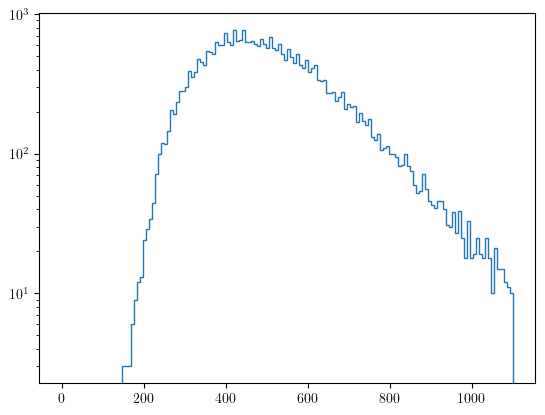

In [9]:
pl.figure()
_ = pl.hist(Npart.flatten(), bins=150, range=(0, 1100), histtype='step')
pl.yscale('log')






In [10]:
# elif grid == 128:
BoxSize = 1000.
grid = 32
nMax_h = 1100
dfpart_ngp_wxyz = np.float32(np.zeros((grid, grid, grid, nMax_h, 3)))
NGP_xyz(np.float32(pos_m_truth), dfpart_ngp_wxyz, BoxSize)




In [11]:
# dfpart_ngp_wxyz[0,0,0,:,0]


In [12]:
# norm_delta = 1000
# if j1 == 0:
#     jn1 = grid - 1
# else:
#     jn1 = j1 - 1
# if j1 == grid - 1:
#     jp1 = 0
# else:
#     jp1 = j1 + 1

# jp1_all = [jn1, j1, jp1]

# if j2 == 0:
#     jn2 = grid - 1
# else:
#     jn2 = j2 - 1

# if j2 == grid - 1:
#     jp2 = 0
# else:
#     jp2 = j2 + 1

# jp2_all = [jn2, j2, jp2]

# if j3 == 0:
#     jn3 = grid - 1
# else:
#     jn3 = j3 - 1

# if j3 == grid - 1:
#     jp3 = 0
# else:
#     jp3 = j3 + 1

# jp3_all = [jn3, j3, jp3]

# coord_add_sign = [-1,0,1]
# # x_all_part = np.concatenate((dfpart_ngp_wxyz[j1,j2,j3], dfpart_ngp_wxyz[jp1,j2,j3], dfpart_ngp_wxyz[jn1,j2,j3], dfpart_ngp_wxyz[j1,jp2,j3], dfpart_ngp_wxyz[j1,jn2,j3], dfpart_ngp_wxyz[j1,j2,jp3], dfpart_ngp_wxyz[j1,j2,jn3]))
# # indpos = np.where(dfpart_ngp_wxyz[j1,j2,j3][:,0] != 0)[0]
# # print(indpos.shape)
# # all_part0 = dfpart_ngp_wxyz[j1,j2,j3][indpos,:]
# all_part = []
# for i1 in range(3):
#     for i2 in range(3):
#         for i3 in range(3):
#             all_part_here = dfpart_ngp_wxyz[jp1_all[i1],jp2_all[i2],jp3_all[i3]]
#             indpos = np.where(all_part_here[:,0] != 0)[0]
#             all_part_here = all_part_here[indpos,:]
#             all_part_here[:,0] = all_part_here[:,0] + coord_add_sign[i1]*BoxSize/(grid)
#             all_part_here[:,1] = all_part_here[:,1] + coord_add_sign[i2]*BoxSize/(grid)
#             all_part_here[:,2] = all_part_here[:,2] + coord_add_sign[i3]*BoxSize/(grid)

#             if len(all_part) == 0:
#                 all_part = all_part_here
#             else:
#                 all_part = np.vstack((all_part, all_part_here))

# grid_sbox = 64
# MAS = 'NGP'
# verbose = False

# box_size_sbox = BoxSize/(2*grid)
# all_part0_sel = np.where((all_part[:,0] > -box_size_sbox) & (all_part[:,0] < box_size_sbox) & (all_part[:,1] > -box_size_sbox) & (all_part[:,1] < box_size_sbox) & (all_part[:,2] > -box_size_sbox) & (all_part[:,2] < box_size_sbox))[0]
# all_part0 = all_part[all_part0_sel]
# delta_sbox0 = np.zeros((grid_sbox,grid_sbox,grid_sbox), dtype=np.float32)
# MASL.MA(all_part0 + box_size_sbox, delta_sbox0, (2*box_size_sbox), MAS, verbose=verbose)
# nbar0 = (npart_test/BoxSize**3)*((2*box_size_sbox)/grid_sbox)**3
# delta_sbox0 /= nbar0
# delta_sbox0 /= norm_delta


# box_size_sbox = 2*BoxSize/(2*grid)
# all_part1_sel = np.where((all_part[:,0] > -box_size_sbox) & (all_part[:,0] < box_size_sbox) & (all_part[:,1] > -box_size_sbox) & (all_part[:,1] < box_size_sbox) & (all_part[:,2] > -box_size_sbox) & (all_part[:,2] < box_size_sbox))[0]
# all_part1 = all_part[all_part1_sel]
# delta_sbox1 = np.zeros((grid_sbox,grid_sbox,grid_sbox), dtype=np.float32)
# MASL.MA(all_part1 + box_size_sbox, delta_sbox1, (2*box_size_sbox), MAS, verbose=verbose)
# nbar1 = (npart_test/BoxSize**3)*((2*box_size_sbox)/grid_sbox)**3
# delta_sbox1 /= nbar1
# delta_sbox1 /= norm_delta


# box_size_sbox = 3*BoxSize/(2*grid)
# all_part2 = all_part
# delta_sbox2 = np.zeros((grid_sbox,grid_sbox,grid_sbox), dtype=np.float32)
# MASL.MA(all_part2 + box_size_sbox, delta_sbox2, (2*box_size_sbox), MAS, verbose=verbose)
# nbar2 = (npart_test/BoxSize**3)*((2*box_size_sbox)/grid_sbox)**3
# delta_sbox2 /= nbar2
# delta_sbox2 /= norm_delta

# delta_sbox_all = np.stack((delta_sbox0, delta_sbox1, delta_sbox2))




In [13]:
# delta_sbox_all.shape


In [14]:
# pl.figure()
# _ = pl.hist(delta_sbox_all.flatten(), bins=1000, range=(0, 10), histtype='step', label='0')
# pl.yscale('log')
# # 1000**3


In [15]:
# np.amax(delta_sbox0), np.amax(delta_sbox1), np.amax(delta_sbox2)
# np.mean(delta_sbox0), np.mean(delta_sbox1), np.mean(delta_sbox2)



In [16]:
# # all_part0.shape, all_part1.shape, all_part2.shape, all_part3.shape, all_part4.shape, all_part5.shape, all_part6.shape, all_part.shape
# pl.figure()
# pl.imshow(np.sum(delta_sbox0[:,:,:], axis=0))
# pl.colorbar()



In [17]:
# # all_part0.shape, all_part1.shape, all_part2.shape, all_part3.shape, all_part4.shape, all_part5.shape, all_part6.shape, all_part.shape
# pl.figure()
# pl.imshow(np.sum(delta_sbox1[:,:,:], axis=0))
# pl.colorbar()


In [18]:
# # all_part0.shape, all_part1.shape, all_part2.shape, all_part3.shape, all_part4.shape, all_part5.shape, all_part6.shape, all_part.shape
# pl.figure()
# pl.imshow(np.sum(delta_sbox2[:,:,:], axis=0))
# pl.colorbar()


In [19]:
# all_part.shape
# x_all_part = all_part[:,0]
# y_all_part = all_part[:,1]
# z_all_part = all_part[:,2]

# ind_pos = np.where(x_all_part != -1000)[0]
# xyz_all = np.array([x_all_part[ind_pos], y_all_part[ind_pos], z_all_part[ind_pos]]).T

# np.amin(all_part), np.amax(all_part)



In [20]:
# xyz_all.shape,
# np.amin(xyz_all), np.amax(xyz_all)
# all_part + 1.5*(BoxSize/grid)


In [21]:
# grid_sbox = 32
# MAS = 'NGP'
# verbose = False
# delta_sbox = np.zeros((grid_sbox,grid_sbox,grid_sbox), dtype=np.float32)
# MASL.MA(all_part + 1.5*(BoxSize/grid), delta_sbox, (3.*(BoxSize/grid)), MAS, verbose=verbose)


In [22]:
# pl.figure()
# pl.imshow(np.sum(delta_sbox[:,:,:], axis=0))


In [23]:
from tqdm import tqdm
norm_delta = 1000            
grid_sbox = 32
MAS = 'NGP'
verbose = False
delta_box_all = np.zeros((grid, grid, grid, grid_sbox, grid_sbox, grid_sbox, 3))
for j1 in tqdm(range(grid)):
    for j2 in range(grid):
        for j3 in range(grid):
            
            if j1 == 0:
                jn1 = grid - 1
            else:
                jn1 = j1 - 1
            if j1 == grid - 1:
                jp1 = 0
            else:
                jp1 = j1 + 1

            jp1_all = [jn1, j1, jp1]

            if j2 == 0:
                jn2 = grid - 1
            else:
                jn2 = j2 - 1

            if j2 == grid - 1:
                jp2 = 0
            else:
                jp2 = j2 + 1

            jp2_all = [jn2, j2, jp2]

            if j3 == 0:
                jn3 = grid - 1
            else:
                jn3 = j3 - 1

            if j3 == grid - 1:
                jp3 = 0
            else:
                jp3 = j3 + 1

            jp3_all = [jn3, j3, jp3]

            coord_add_sign = [-1,0,1]
            all_part = []
            for i1 in range(3):
                for i2 in range(3):
                    for i3 in range(3):
                        all_part_here = dfpart_ngp_wxyz[jp1_all[i1],jp2_all[i2],jp3_all[i3]]
                        indpos = np.where(all_part_here[:,0] != 0)[0]
                        all_part_here = all_part_here[indpos,:]
                        all_part_here[:,0] = all_part_here[:,0] + coord_add_sign[i1]*BoxSize/(grid)
                        all_part_here[:,1] = all_part_here[:,1] + coord_add_sign[i2]*BoxSize/(grid)
                        all_part_here[:,2] = all_part_here[:,2] + coord_add_sign[i3]*BoxSize/(grid)

                        if len(all_part) == 0:
                            all_part = all_part_here
                        else:
                            all_part = np.vstack((all_part, all_part_here))



            box_size_sbox = BoxSize/(2*grid)
            all_part0_sel = np.where((all_part[:,0] > -box_size_sbox) & (all_part[:,0] < box_size_sbox) & (all_part[:,1] > -box_size_sbox) & (all_part[:,1] < box_size_sbox) & (all_part[:,2] > -box_size_sbox) & (all_part[:,2] < box_size_sbox))[0]
            all_part0 = all_part[all_part0_sel]
            delta_sbox0 = np.zeros((grid_sbox,grid_sbox,grid_sbox), dtype=np.float32)
            MASL.MA(all_part0 + box_size_sbox, delta_sbox0, (2*box_size_sbox), MAS, verbose=verbose)
            nbar0 = (npart_test/BoxSize**3)*((2*box_size_sbox)/grid_sbox)**3
            delta_sbox0 /= nbar0
            delta_sbox0 /= norm_delta


            box_size_sbox = 2*BoxSize/(2*grid)
            all_part1_sel = np.where((all_part[:,0] > -box_size_sbox) & (all_part[:,0] < box_size_sbox) & (all_part[:,1] > -box_size_sbox) & (all_part[:,1] < box_size_sbox) & (all_part[:,2] > -box_size_sbox) & (all_part[:,2] < box_size_sbox))[0]
            all_part1 = all_part[all_part1_sel]
            delta_sbox1 = np.zeros((grid_sbox,grid_sbox,grid_sbox), dtype=np.float32)
            MASL.MA(all_part1 + box_size_sbox, delta_sbox1, (2*box_size_sbox), MAS, verbose=verbose)
            nbar1 = (npart_test/BoxSize**3)*((2*box_size_sbox)/grid_sbox)**3
            delta_sbox1 /= nbar1
            delta_sbox1 /= norm_delta


            box_size_sbox = 3*BoxSize/(2*grid)
            all_part2 = all_part
            delta_sbox2 = np.zeros((grid_sbox,grid_sbox,grid_sbox), dtype=np.float32)
            MASL.MA(all_part2 + box_size_sbox, delta_sbox2, (2*box_size_sbox), MAS, verbose=verbose)
            nbar2 = (npart_test/BoxSize**3)*((2*box_size_sbox)/grid_sbox)**3
            delta_sbox2 /= nbar2
            delta_sbox2 /= norm_delta

            delta_sbox_all = np.stack((delta_sbox0, delta_sbox1, delta_sbox2))

            # move first axis to last:
            delta_sbox_all = np.moveaxis(delta_sbox_all, 0, -1)

            delta_box_all[j1,j2,j3] = delta_sbox_all




  0%|          | 0/32 [00:00<?, ?it/s]

100%|██████████| 32/32 [00:48<00:00,  1.52s/it]


In [24]:
delta_box_all_squeezed = np.reshape(delta_box_all, (grid*grid*grid, grid_sbox, grid_sbox, grid_sbox, 3))



In [25]:
# elif grid == 128:
BoxSize = 1000.
grid = 32
nMax_h = 32
dfhalo_ngp_wxyzM = np.float32(np.zeros((grid, grid, grid, nMax_h, 4)))
NGP_xyzM(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wxyzM, BoxSize)




In [26]:
# dfhalo_ngp_wxyzM_squeezed = np.reshape(dfhalo_ngp_wxyzM, (grid*grid*grid, nMax_h, 4))
Nhalos_truth = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_h_truth), Nhalos_truth, BoxSize)



In [27]:
M_halos_argsort = np.flip(np.argsort(dfhalo_ngp_wxyzM[:,:,:,:,3], axis=-1), axis=-1)
xmin = BoxSize/grid/2
lgMin = np.log10(Mmin_cut)
lgMax = 15.5
dfhalo_ngp_xyzM_sorted_scaled = np.zeros_like(dfhalo_ngp_wxyzM)
for i1 in range(grid):
    for i2 in range(grid):
        for i3 in range(grid):
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 0] = dfhalo_ngp_wxyzM[i1, i2, i3, M_halos_argsort[i1, i2, i3], 0]
            indpos_x = np.where(dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 0] != 0.0)[0]
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_x, 0] = (dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_x, 0] + xmin)/(2*xmin)

            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 1] = dfhalo_ngp_wxyzM[i1, i2, i3, M_halos_argsort[i1, i2, i3], 1]
            indpos_y = np.where(dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 1] != 0.0)[0]
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_y, 1] = (dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_y, 1] + xmin)/(2*xmin)

            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 2] = dfhalo_ngp_wxyzM[i1, i2, i3, M_halos_argsort[i1, i2, i3], 2]
            indpos_z = np.where(dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 2] != 0.0)[0]
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_z, 2] = (dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_z, 2] + xmin)/(2*xmin)

            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 3] = dfhalo_ngp_wxyzM[i1, i2, i3, M_halos_argsort[i1, i2, i3], 3]
            indpos_M = np.where(dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, :, 3] != 0.0)[0]
            dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_M, 3] = (dfhalo_ngp_xyzM_sorted_scaled[i1, i2, i3, indpos_M, 3] - lgMin)/(lgMax - lgMin)






In [28]:
indzeros = np.where(dfhalo_ngp_xyzM_sorted_scaled == 0.0)
dfhalo_ngp_xyzM_sorted_scaled[indzeros] = -1.0




In [29]:
# np.amin(dfhalo_ngp_xyzM_sorted_scaled), np.amax(dfhalo_ngp_xyzM_sorted_scaled)
nvocab = 128
bins_digitize = np.linspace(-1e-3, 1, nvocab)
# bins_digitize.insert(0, -1)
bins_digitize = np.insert(bins_digitize, 0, -1)
# bins_digitize
dfhalo_ngp_xyzM_sorted_scaled_digitized = np.digitize(dfhalo_ngp_xyzM_sorted_scaled, bins_digitize)




In [30]:
# dfhalo_ngp_xyzM_sorted_scaled[0,0,0,:,0]
np.amax(dfhalo_ngp_xyzM_sorted_scaled_digitized)



128

In [31]:
start_token = 0
pad_token = 1
end_token = nvocab + 1
space_token = nvocab + 2
max_sentence_length = 1 + nMax_h*4 + 1 + (nMax_h-1)
dfhalo_ngp_xyzM_tokenized = np.zeros((grid, grid, grid, max_sentence_length), dtype=np.int32) + end_token

dfhalo_ngp_xyzM_tokenized[..., 0] = start_token
# for jh in range(nMax_h):
jh = 1
while jh < 5*nMax_h:
    # if dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh, 0] > 1:
    dfhalo_ngp_xyzM_tokenized[..., jh + 0] = dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh//5, 3]
    dfhalo_ngp_xyzM_tokenized[..., jh + 1] = dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh//5, 0]
    dfhalo_ngp_xyzM_tokenized[..., jh + 2] = dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh//5, 1]
    dfhalo_ngp_xyzM_tokenized[..., jh + 3] = dfhalo_ngp_xyzM_sorted_scaled_digitized[..., jh//5, 2]
    if jh//5 < nMax_h - 1:
        dfhalo_ngp_xyzM_tokenized[..., jh + 4] = space_token
    # else:
    #     dfhalo_ngp_xyzM_tokenized[..., 1 + nMax_h*4] = end_token
    jh += 5





In [32]:
dfhalo_ngp_xyzM_tokenized_padded_ended = np.copy(dfhalo_ngp_xyzM_tokenized)
for i1 in range(grid):
    for i2 in range(grid):
        for i3 in range(grid):
            ind1 = np.where(dfhalo_ngp_xyzM_tokenized[i1, i2, i3,:] == 1)[0]
            try:
                ind1 = ind1[0]
                dfhalo_ngp_xyzM_tokenized_padded_ended[i1, i2, i3, ind1-1] = end_token
                dfhalo_ngp_xyzM_tokenized_padded_ended[i1, i2, i3, ind1:] = pad_token
            except:
                dfhalo_ngp_xyzM_tokenized_padded_ended[i1, i2, i3, ind1-1] = end_token
                # dfhalo_ngp_xyzM_tokenized_padded_ended[i1, i2, i3, ind1:] = pad_token




In [33]:
dfhalo_ngp_xyzM_tokenized_padded_ended[0,12,0,:]



array([129,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1], dtype=int32)

In [34]:
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed = np.reshape(dfhalo_ngp_xyzM_tokenized_padded_ended, (grid*grid*grid, max_sentence_length))
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed.shape



(32768, 161)

In [36]:
saved = {'dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed':dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed.astype(np.int16),
        'dfhalo_ngp_wxyzM': dfhalo_ngp_wxyzM.astype(np.int16),
        'Nhalos_truth': Nhalos_truth.astype(np.int16),
        'delta_box_all_squeezed': delta_box_all_squeezed.astype(np.float32)}

pk.dump(saved, open(f'/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_{grid_sbox}_isim_{isim_fid}_snap_{snapnum}.pkl', 'wb'))


# save to disk in binary format to easy reading with memmap:


In [7]:

df = pk.load(open('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_0_snap_3.pkl','rb'))

dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0 = df['dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed']
dfhalo_ngp_wxyzM_0 = df['dfhalo_ngp_wxyzM']
Nhalos_truth_0 = df['Nhalos_truth']
delta_box_all_squeezed_0 = df['delta_box_all_squeezed']


df = pk.load(open('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_1_snap_3.pkl','rb'))

dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_1 = df['dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed']
dfhalo_ngp_wxyzM_1 = df['dfhalo_ngp_wxyzM']
Nhalos_truth_1 = df['Nhalos_truth']
delta_box_all_squeezed_1= df['delta_box_all_squeezed']


df = pk.load(open('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_2_snap_3.pkl','rb'))

dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_2 = df['dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed']
dfhalo_ngp_wxyzM_2 = df['dfhalo_ngp_wxyzM']
Nhalos_truth_2 = df['Nhalos_truth']
delta_box_all_squeezed_2 = df['delta_box_all_squeezed']




In [8]:
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all = np.vstack((dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0, dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_1, dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_2)).astype(np.int16)



In [9]:
delta_box_all_squeezed_all = np.vstack((delta_box_all_squeezed_0, delta_box_all_squeezed_1, delta_box_all_squeezed_2)).astype(np.float32)
delta_box_all_squeezed_all = np.moveaxis(delta_box_all_squeezed_all, -1, 1)


In [ ]:
grid = dfhalo_ngp_wxyzM_0.shape[0]
dfhalo_ngp_wxyzM_0_reshape = np.reshape(dfhalo_ngp_wxyzM_0, (grid*grid*grid, 32, 4))
dfhalo_ngp_wxyzM_1_reshape = np.reshape(dfhalo_ngp_wxyzM_1, (grid*grid*grid, 32, 4))
dfhalo_ngp_wxyzM_2_reshape = np.reshape(dfhalo_ngp_wxyzM_2, (grid*grid*grid, 32, 4))
dfhalo_ngp_wxyzM_reshape_all = np.vstack((dfhalo_ngp_wxyzM_0_reshape, dfhalo_ngp_wxyzM_1_reshape, dfhalo_ngp_wxyzM_2_reshape)).astype(np.float32)



In [ ]:
Nhalos_truth_0_reshape = np.reshape(Nhalos_truth_0, (grid*grid*grid))
Nhalos_truth_1_reshape = np.reshape(Nhalos_truth_1, (grid*grid*grid))
Nhalos_truth_2_reshape = np.reshape(Nhalos_truth_2, (grid*grid*grid))
Nhalos_truth_reshape_all = np.concatenate((Nhalos_truth_0_reshape, Nhalos_truth_1_reshape, Nhalos_truth_2_reshape)).astype(np.int16)



In [10]:
# save using h5py
import h5py as h5
f = h5.File('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_012_snap_3.h5', 'w')
f.create_dataset('dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all', data=dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all)
f.create_dataset('delta_box_all_squeezed_all', data=delta_box_all_squeezed_all)
f.create_dataset('dfhalo_ngp_wxyzM_reshape_all', data=dfhalo_ngp_wxyzM_reshape_all)
f.create_dataset('Nhalos_truth_reshape_all', data=Nhalos_truth_reshape_all)
f.close()



In [14]:
# dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all.shape
# dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_0.shape
# dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all.dtype
sdir = '/mnt/home/spandey/ceph/CHARFORMER/data/'
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all.tofile(sdir + 'dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_isim_0_to_2.bin')



In [16]:
# delta_box_all_squeezed_2.shape
delta_box_all_squeezed_all = np.vstack((delta_box_all_squeezed_0, delta_box_all_squeezed_1, delta_box_all_squeezed_2))
delta_box_all_squeezed_all = np.moveaxis(delta_box_all_squeezed, -1, 1)
delta_box_all_squeezed_all.shape


: 

In [ ]:
delta_box_all_squeezed_all.tofile(sdir + 'dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_isim_0_to_2.bin')



In [ ]:
dfhalo_ngp_wxyzM_all = np.vstack((dfhalo_ngp_wxyzM_0, dfhalo_ngp_wxyzM_1, dfhalo_ngp_wxyzM_2))
print(dfhalo_ngp_wxyzM_all.shape)



In [ ]:
dfhalo_ngp_wxyzM_reshape_all = np.vstack((dfhalo_ngp_wxyzM_0_reshape, dfhalo_ngp_wxyzM_1_reshape, dfhalo_ngp_wxyzM_2_reshape))

In [ ]:
Nhalos_truth_reshape_all = np.concatenate((Nhalos_truth_0_reshape, Nhalos_truth_1_reshape, Nhalos_truth_2_reshape))



In [ ]:
dfhalo_ngp_wxyzM_reshape_all.tofile(sdir + 'dfhalo_ngp_wxyzM_reshape_all_squeezed_isim_0_to_2.bin')




In [ ]:
# Nhalos_truth_0_reshape = np.reshape(Nhalos_truth_0.shape, (grid*grid*grid))
Nhalos_truth_reshape_all.tofile(sdir + 'Nhalos_truth_reshape_all_squeezed_isim_0_to_2.bin')


In [1]:
import numpy as np
import h5py as h5

f = h5.File('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_012_snap_3.h5', 'r')
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all = f['dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all'][:]
delta_box_all_squeezed_all = f['delta_box_all_squeezed_all'][:]
f.close()






In [3]:
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_all.shape



(98304, 161)

In [4]:
delta_box_all_squeezed_all.shape



(98304, 3, 32, 32, 32)